In [1]:
import os
import rsnapsim as rss
import numpy as np
print('numpy version =', np.version.version)
print('rsnapsim version =',rss.__version__)
from sys import platform
import os
from skimage import io ; from skimage.io import imread; from skimage.measure import find_contours
from random import randrange
import os; from os import listdir; from os.path import isfile, join
import pandas as pd
import os; from os import listdir; from os.path import isfile, join
import re
import shutil
from random import randrange
# Importing rSNAPsim_IP
cwd = os.getcwd(); os.chdir('../../rsnaped'); import rsnaped as rsp ; os.chdir(cwd) # return to the working directory
import ipywidgets as widgets ; from ipywidgets import interact, interactive, fixed, interact_manual, Button, HBox, VBox, Layout, GridspecLayout ; from IPython.display import Image

numpy version = 1.19.2
rsnapsim version = 0.0.16


In [2]:
import matplotlib.pyplot as plt
plt.style.use('dark_background')
plt.rcParams['figure.dpi'] = 120
plt.rcParams['lines.linewidth'] = 1
plt.rcParams['axes.linewidth'] = 1.5
plt.rcParams['font.size'] = 15
plt.rcParams['axes.grid'] = False

In [3]:
number_spots_per_cell = 40
simulation_time_in_sec = 60
step_size_in_sec =1

# Running SSA

In [4]:
gene_file_h2b = '../../DataBases/gene_files/H2B_withTags.txt'
gene_file_bact = '../../DataBases/gene_files/Bactin_withTags.txt'

In [5]:
def rsnapsim_ssa(gene_file,ke =3,ki=0.033,frames=100,n_traj=20):
    poi_strs, poi_objs, tagged_pois,raw_seq = rss.seqmanip.open_seq_file(gene_file)
    gene_obj = tagged_pois['1'][0]
    gene_obj.ke = ke
    rss.solver.protein = gene_obj #pass the protein object
    t_burnin = 1000
    t = np.linspace(0,t_burnin+frames,t_burnin+frames+1)
    
    
    ssa_solution = rss.solver.solve_ssa(gene_obj.kelong, t, ki=ki, kt = ke, low_memory=False,record_stats=False,n_traj=n_traj)
    
    
    time = ssa_solution.time[t_burnin:-1]
    time= time-t_burnin
    ssa_int =  ssa_solution.intensity_vec[0,t_burnin:-1,:].T
    return ssa_solution.time[t_burnin:-1], ssa_int

## Running the SSA for two genes (H2B and b-act)

In [6]:
t, ssa_solution_h2b = rsnapsim_ssa(gene_file_h2b,frames=simulation_time_in_sec,n_traj=number_spots_per_cell)

C++ library failed, Using Python Implementation


In [7]:
t, ssa_solution_b_act = rsnapsim_ssa(gene_file_bact,frames=simulation_time_in_sec,n_traj=number_spots_per_cell)

C++ library failed, Using Python Implementation


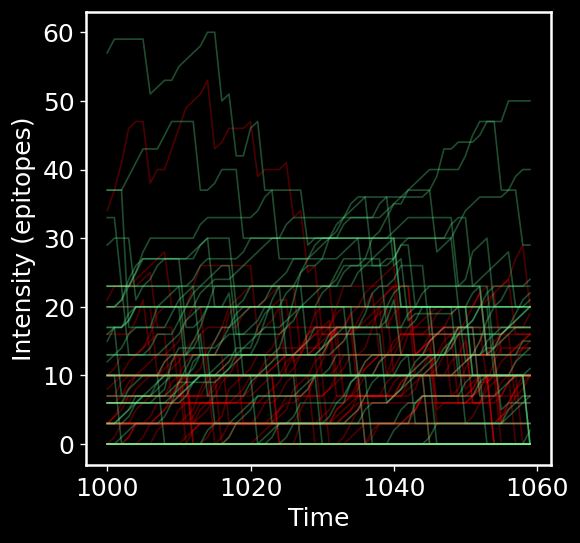

In [8]:
plt.rcParams['figure.figsize'] = [5, 5]
plt.plot(t,ssa_solution_h2b.T,color='r',alpha=.3 );
plt.plot(t,ssa_solution_b_act.T,color='#66FF99',alpha=.3 );
plt.xlabel('Time')
plt.ylabel('Intensity (epitopes)')
plt.show()

# Generating Simulated Cell

## Generating the inital video from empty cells

In [9]:
ouput_directory_name = '../../DataBases/videos_for_sim_cell'
list_files_names = sorted([f for f in listdir(ouput_directory_name) if isfile(join(ouput_directory_name, f)) and ('.tif') in f], key=str.lower)  # reading all tif files in the folder
list_files_names.sort(key=lambda f: int(re.sub('\D', '', f)))  # sorting the index in numerical order
path_files = [ ouput_directory_name+'/'+f for f in list_files_names ] # creating the complete path for each file
num_cell_shapes = len(path_files)
sel_shape = randrange(num_cell_shapes)
sel_shape = 1
print(sel_shape)
video_path = path_files[sel_shape]
inial_video = io.imread(video_path) 

1


In [10]:
intensity_calculation_method = 'disk_donut'  # options are : 'total_intensity' and 'disk_donut' 'gaussian_fit'

## Main function that creates the videos form SSA

In [11]:
def simCell_for_ML (base_video,video_for_mask=None, ssa=None, target_channel=1, diffusion_coefficient=0.05, step_size=1,spot_size=5, spot_sigma=2,intensity_calculation_method='gaussian_fit'):
    if target_channel ==0:
        ignore_ch0=0; ignore_ch1=1; ignore_ch2=1
    elif target_channel ==1:
        ignore_ch0=0; ignore_ch1=0; ignore_ch2=1
    elif target_channel ==2:
        ignore_ch0=0; ignore_ch1=1; ignore_ch2=0
    number_spots_per_cell = ssa.shape[0]
    simulation_time_in_sec =  ssa.shape[1]  # THIS NEEDS TO BE UPDATED TO ALLOW THE USER TO GIVE DIFFERENT STEP_SIZE
    tensor_video , _ , _, _, _, DataFrame_particles_intensities = rsp.SimulatedCell( base_video=base_video,video_for_mask=video_for_mask, number_spots = number_spots_per_cell, number_frames=simulation_time_in_sec, step_size=step_size_in_sec, diffusion_coefficient =diffusion_coefficient, simulated_trajectories_ch0=None, size_spot_ch0=spot_size, spot_sigma_ch0=spot_sigma, simulated_trajectories_ch1=ssa, size_spot_ch1=spot_size, spot_sigma_ch1=spot_sigma, simulated_trajectories_ch2=ssa, size_spot_ch2=spot_size, spot_sigma_ch2=spot_sigma, ignore_ch0=ignore_ch0,ignore_ch1=ignore_ch1, ignore_ch2=ignore_ch2,save_as_tif_uint8=0,save_as_tif =0,save_as_gif=0, save_dataframe=0, saved_file_name=None,create_temp_folder = False,intensity_calculation_method=intensity_calculation_method).make_simulation()      
    return tensor_video, DataFrame_particles_intensities

In [12]:
tensor_video , DataFrame_particles_intensities_h2b = simCell_for_ML (inial_video, ssa=ssa_solution_h2b, target_channel=1, diffusion_coefficient=0.5,intensity_calculation_method=intensity_calculation_method)

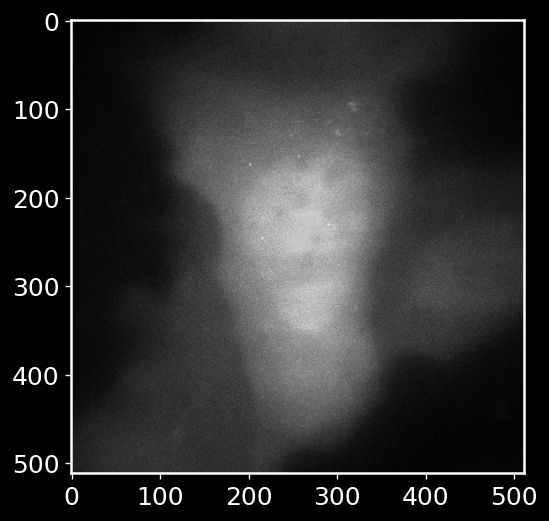

In [13]:
plt.rcParams['figure.figsize'] = [5, 5]
plt.imshow(tensor_video[1,:,:,1],cmap='gray')
plt.show(); 

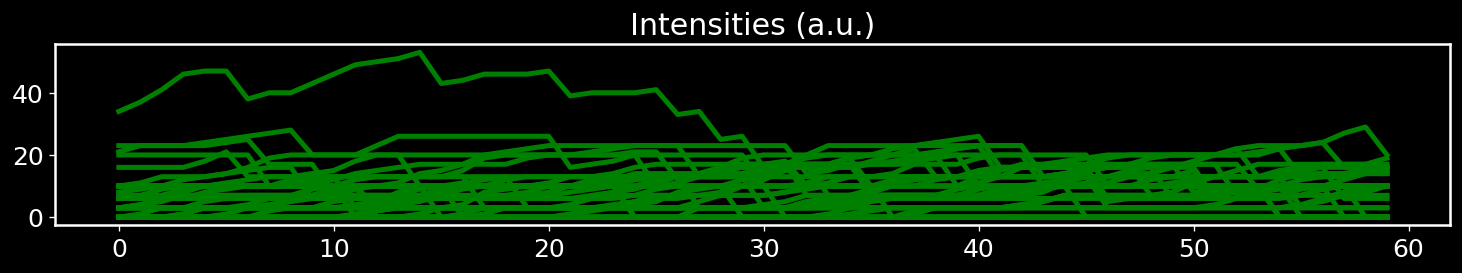

In [14]:
plt.figure(figsize=(15,2))
for tr in range(0,ssa_solution_h2b.shape[0] ):
    tmp_int = DataFrame_particles_intensities_h2b[DataFrame_particles_intensities_h2b['particle'] ==tr].green_int_mean.values
    tmp_time = DataFrame_particles_intensities_h2b[DataFrame_particles_intensities_h2b['particle'] ==tr].frame.values
    #plt.plot(tmp_time,tmp_int , 'o',linewidth = 3, markersize=7,color='m')
    plt.plot(ssa_solution_h2b[tr,:] , '-',linewidth = 3,color='green');
plt.title('Intensities (a.u.)')
plt.show()

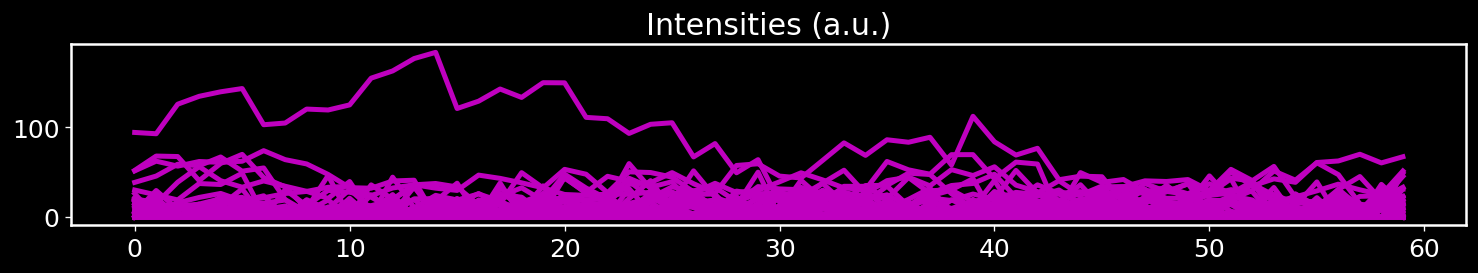

In [15]:
plt.figure(figsize=(15,2))
for tr in range(0,ssa_solution_h2b.shape[0] ):
    tmp_int = DataFrame_particles_intensities_h2b[DataFrame_particles_intensities_h2b['particle'] ==tr].green_int_mean.values
    tmp_time = DataFrame_particles_intensities_h2b[DataFrame_particles_intensities_h2b['particle'] ==tr].frame.values
    plt.plot(tmp_time,tmp_int , '-',linewidth = 3, markersize=7,color='m')
    #plt.plot(ssa_solution_h2b[tr,:] , '-',linewidth = 3,color='green');
#plt.legend(["SSA", "Calculated"], loc ="top right") 
plt.title('Intensities (a.u.)')
plt.show()

In [16]:
DataFrame_particles_intensities_h2b

,cell_number,particle,frame,red_int_mean,green_int_mean,blue_int_mean,red_int_std,green_int_std,blue_int_std,x,y
0,0,0,0,0.000000,0.000000,0.0,69.943827,61.292318,NaN,293.0,347.0
1,0,0,1,43.788570,0.000000,0.0,67.804816,43.976004,NaN,293.0,348.0
2,0,0,2,100.908569,10.720000,0.0,70.644049,47.514453,NaN,293.0,348.0
3,0,0,3,85.594284,3.184286,0.0,86.998683,47.497642,NaN,293.0,347.0
4,0,0,4,148.957138,21.581429,0.0,71.015831,66.421515,NaN,291.0,348.0
...,...,...,...,...,...,...,...,...,...,...,...
2395,0,39,55,118.712860,13.668571,0.0,78.313960,41.207786,NaN,324.0,133.0
2396,0,39,56,44.435715,13.102858,0.0,50.888768,35.983407,NaN,324.0,132.0
2397,0,39,57,46.147144,0.000000,0.0,50.542045,36.046820,NaN,325.0,132.0
2398,0,39,58,18.927143,11.960000,0.0,62.153875,57.680378,NaN,325.0,132.0


In [17]:
# Plot only selected trajectories
plt.rcParams['figure.figsize'] = [5,5]
controls_pr, output_pr = rsp.VisualizerVideo(tensor_video,dataframe_particles=DataFrame_particles_intensities_h2b,normalize=False).make_video_app()
display(VBox([controls_pr, output_pr])); 

In [18]:
tensor_video , DataFrame_particles_intensities_b_act = simCell_for_ML (tensor_video,video_for_mask=inial_video, ssa=ssa_solution_b_act, target_channel=1, diffusion_coefficient=1)

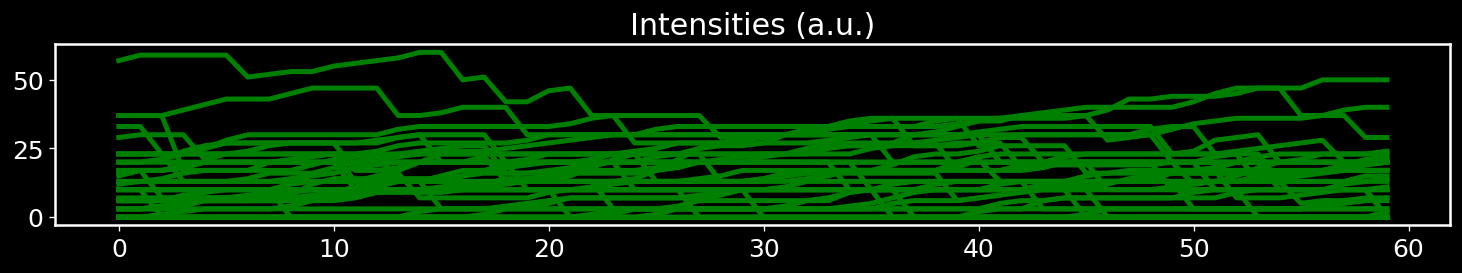

In [19]:
plt.figure(figsize=(15,2))
for tr in range(0,ssa_solution_b_act.shape[0] ):
    plt.plot(ssa_solution_b_act[tr,:] , '-',linewidth = 3,color='green');
plt.title('Intensities (a.u.)')
plt.show()

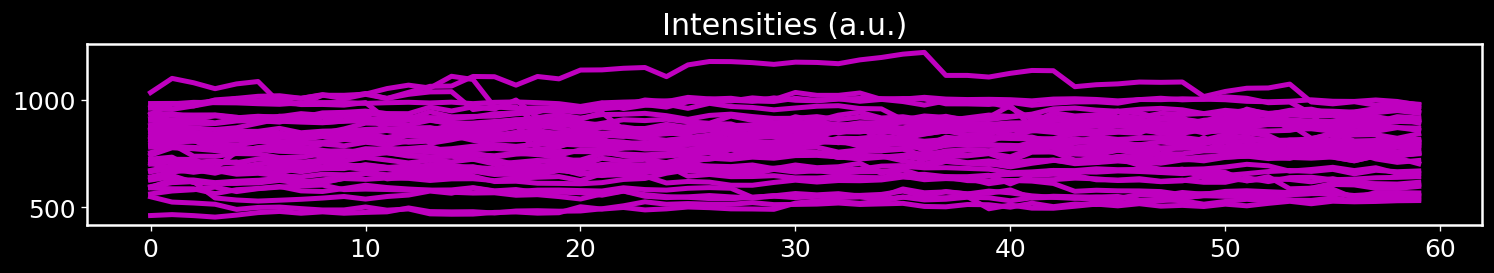

In [20]:
plt.figure(figsize=(15,2))
for tr in range(0,ssa_solution_h2b.shape[0] ):
    tmp_int_b = DataFrame_particles_intensities_b_act[DataFrame_particles_intensities_b_act['particle'] ==tr].green_int_mean.values
    tmp_time_b = DataFrame_particles_intensities_b_act[DataFrame_particles_intensities_b_act['particle'] ==tr].frame.values
    plt.plot(tmp_time_b,tmp_int_b , '-',linewidth = 3, markersize=7,color='m')
plt.title('Intensities (a.u.)')
plt.show()

# Simulated cell with two types of spots on the same channel. Different diffusion_coefficient

In [21]:
# Plot only selected trajectories
plt.rcParams['figure.figsize'] = [7,7]
controls_pr, output_pr = rsp.VisualizerVideo(tensor_video,dataframe_particles=DataFrame_particles_intensities_b_act,normalize=False).make_video_app()
display(VBox([controls_pr, output_pr]));

# Dataframes for the two different genes

In [22]:
#DataFrame_particles_intensities_h2b

In [23]:
#DataFrame_particles_intensities_b_act